In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

In [ ]:
from tensorflow.keras import backend as K

In [ ]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

In [ ]:
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [ ]:
from zipfile import ZipFile
  
with ZipFile("/content/drive/MyDrive/melspec.zip", 'r') as zObject:
  zObject.extractall(path="/content/runtime_data/")
zObject.close()

In [ ]:
from numpy.random import seed
seed(42)
tf.random.set_seed(42)

### Birdcall classfication - Modelling 🐦
Dishita Midha

200968196

## Using EfficientNetB0 

In [ ]:
! pip install -U git+https://github.com/qubvel/efficientnet

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/qubvel/efficientnet to /tmp/pip-req-build-n0chemak
  Running command git clone -q https://github.com/qubvel/efficientnet /tmp/pip-req-build-n0chemak
     |████████████████████████████████| 50 kB 203 kB/s 
  Created wheel for efficientnet: filename=efficientnet-1.1.1-py3-none-any.whl size=18447 sha256=bc1178b936667b54bb5e973cef4ab4bdf50300800c824c8711b49833367244e0
  Stored in directory: /tmp/pip-ephem-wheel-cache-0rkeqd62/wheels/11/69/85/814d64d694c96db0eef17b718042d644a1e54f113920481920
Successfully built efficientnet


In [ ]:
from torch.utils.data import DataLoader, Dataset, random_split
import numpy as np
import pandas as pd
%matplotlib inline
from tqdm.notebook import tqdm
import warnings
warnings.filterwarnings('ignore')
from tqdm.notebook import tqdm
from IPython.display import Image
from PIL import Image
from IPython.display import Audio
from torch.utils.data import DataLoader, Dataset, random_split
from sklearn.preprocessing import LabelEncoder
from numpy import asarray
from sklearn.model_selection import train_test_split
# from torch.utils.data import Dataset, DataLoader
import cv2
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.callbacks import ReduceLROnPlateau, ModelCheckpoint, EarlyStopping
from tensorflow.keras.applications.imagenet_utils import decode_predictions
import efficientnet.tfkeras as efn 
from efficientnet.keras import center_crop_and_resize, preprocess_input
import matplotlib.pyplot as plt
from tensorflow.keras import backend as K
from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.models import Sequential, load_model
from tensorflow.keras.layers import Conv2D, MaxPool2D, Dropout, Flatten, Dense, GlobalAveragePooling2D
from sklearn.metrics import accuracy_score

In [ ]:
chunk0 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_csv/chunk0_0.csv')
chunk1 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_csv/chunk1_1.csv')
chunk2 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_csv/chunk2_2.csv')
chunk3 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_csv/chunk3_3.csv')
chunk4 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_csv/chunk4_4.csv')
chunk5 = pd.read_csv('/content/drive/MyDrive/Colab Notebooks/birdclef-2022/train_csv/chunk5_5.csv')

In [ ]:
birds = pd.concat([chunk0, chunk1, chunk2, chunk3, chunk4, chunk5])
birds

,Unnamed: 0,image_path,specie_type
0,0,/content/drive/MyDrive/spectograms_new/train_i...,bcnher
1,1,/content/drive/MyDrive/spectograms_new/train_i...,bcnher
2,2,/content/drive/MyDrive/spectograms_new/train_i...,bcnher
3,3,/content/drive/MyDrive/spectograms_new/train_i...,bcnher
4,4,/content/drive/MyDrive/spectograms_new/train_i...,bcnher
...,...,...,...
4704,4704,/content/drive/MyDrive/spectograms_new/train_i...,wesmea
4705,4705,/content/drive/MyDrive/spectograms_new/train_i...,wesmea
4706,4706,/content/drive/MyDrive/spectograms_new/train_i...,wesmea
4707,4707,/content/drive/MyDrive/spectograms_new/train_i...,wesmea


In [ ]:
new_image_paths = []
for path in birds['image_path']:
  components = path.split('/MyDrive/')
  path = '/content/runtime_data/' + components[1]
  new_image_paths.append(path)

In [ ]:
birds = birds.assign(runtime_image_path = new_image_paths)
birds

,Unnamed: 0,image_path,specie_type,runtime_image_path
0,0,/content/drive/MyDrive/spectograms_new/train_i...,bcnher,/content/runtime_data/spectograms_new/train_im...
1,1,/content/drive/MyDrive/spectograms_new/train_i...,bcnher,/content/runtime_data/spectograms_new/train_im...
2,2,/content/drive/MyDrive/spectograms_new/train_i...,bcnher,/content/runtime_data/spectograms_new/train_im...
3,3,/content/drive/MyDrive/spectograms_new/train_i...,bcnher,/content/runtime_data/spectograms_new/train_im...
4,4,/content/drive/MyDrive/spectograms_new/train_i...,bcnher,/content/runtime_data/spectograms_new/train_im...
...,...,...,...,...
4704,4704,/content/drive/MyDrive/spectograms_new/train_i...,wesmea,/content/runtime_data/spectograms_new/train_im...
4705,4705,/content/drive/MyDrive/spectograms_new/train_i...,wesmea,/content/runtime_data/spectograms_new/train_im...
4706,4706,/content/drive/MyDrive/spectograms_new/train_i...,wesmea,/content/runtime_data/spectograms_new/train_im...
4707,4707,/content/drive/MyDrive/spectograms_new/train_i...,wesmea,/content/runtime_data/spectograms_new/train_im...


In [ ]:
birds = birds.sample(frac = 1)

In [ ]:
birds = birds[['runtime_image_path', 'specie_type']]

In [ ]:
encoder = LabelEncoder()
birds['primary_label_encoded'] = encoder.fit_transform(birds['specie_type'])

In [ ]:
birds

,runtime_image_path,specie_type,primary_label_encoded
2229,/content/runtime_data/spectograms_new/train_im...,brnowl,2
2774,/content/runtime_data/spectograms_new/train_im...,mallar3,11
1305,/content/runtime_data/spectograms_new/train_im...,houfin,9
2207,/content/runtime_data/spectograms_new/train_im...,norcar,12
2111,/content/runtime_data/spectograms_new/train_im...,houspa,10
...,...,...,...
10774,/content/runtime_data/spectograms_new/train_im...,normoc,13
3003,/content/runtime_data/spectograms_new/train_im...,dunlin,5
860,/content/runtime_data/spectograms_new/train_im...,bcnher,0
4994,/content/runtime_data/spectograms_new/train_im...,normoc,13


In [ ]:
#splitting dataset into train test and validation
train_ratio = 0.80
validation_ratio = 0.10
test_ratio = 0.10

train = birds['runtime_image_path']
test = birds['specie_type']

X_train, X_test, y_train, y_test = train_test_split(train, test, test_size= 1 - train_ratio)

X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size = test_ratio/(test_ratio + validation_ratio)) 


In [ ]:
def generate_df(X, y):
  df = pd.DataFrame()
  df['runtime_image_path'] = X
  df['specie_type'] = y
  return df

train_df = generate_df(X_train, y_train)
val_df = generate_df(X_val, y_val)
test_df = generate_df(X_test, y_test)


In [ ]:
class config:
  size = (224, 224)
  epochs = 20

## Creating data generators for train, test, val

In [ ]:
birds_classes= [*set(birds['specie_type'].tolist())]

train_datagen = ImageDataGenerator(preprocessing_function=preprocess_input,  
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.1,
                                   fill_mode='nearest')
valid_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)


In [ ]:
test_datagen = ImageDataGenerator(preprocessing_function=preprocess_input)



### Another type of data generator

In [ ]:
train_generator=train_datagen.flow_from_dataframe(
dataframe=train_df,
directory=None,
x_col="runtime_image_path",
y_col="specie_type",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=config.size)

Found 21110 validated image filenames belonging to 17 classes.


In [ ]:
valid_generator=valid_datagen.flow_from_dataframe(
dataframe=val_df,
directory=None,
x_col="runtime_image_path",
y_col="specie_type",
batch_size=16,
shuffle=True,
class_mode="categorical",
target_size=config.size)

Found 2639 validated image filenames belonging to 17 classes.


In [ ]:
test_generator=test_datagen.flow_from_dataframe(
dataframe=test_df,
directory=None,
x_col="runtime_image_path",
y_col=None,
batch_size=16,
shuffle=False,
class_mode=None,
target_size=config.size)

Found 2639 validated image filenames.


In [ ]:
birds_encoding2 = {}
print('****************')
for cls, idx in train_generator.class_indices.items():
    print('Class nr ',idx,' -> ', cls)
    birds_encoding2[cls] = idx
print('****************')

****************
Class nr  0  ->  bcnher
Class nr  1  ->  bkbplo
Class nr  2  ->  brnowl
Class nr  3  ->  cangoo
Class nr  4  ->  comsan
Class nr  5  ->  dunlin
Class nr  6  ->  eurwig
Class nr  7  ->  gnwtea
Class nr  8  ->  gwfgoo
Class nr  9  ->  houfin
Class nr  10  ->  houspa
Class nr  11  ->  mallar3
Class nr  12  ->  norcar
Class nr  13  ->  normoc
Class nr  14  ->  rorpar
Class nr  15  ->  skylar
Class nr  16  ->  wesmea
****************


# MODEL

In [ ]:
efnb0 = efn.EfficientNetB0(weights='imagenet', include_top=False, input_shape=(224,224,3), classes=17)

model = Sequential()
model.add(efnb0)
model.add(GlobalAveragePooling2D())
model.add(Dropout(0.5))
model.add(Dense(17, activation='softmax'))

model.summary()

16804768/16804768 [==============================] - 1s 0us/step
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 efficientnet-b0 (Functional  (None, 7, 7, 1280)       4049564   
 )                                                               
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dropout (Dropout)           (None, 1280)              0         
                                                                 
 dense (Dense)               (None, 17)                21777     
                                                                 
Total params: 4,071,341
Trainable params: 4,029,325
Non-trainable params: 42,016
__________________________________________

In [ ]:
optimizer = Adam(lr=0.0001)

#early stopping to monitor the validation loss and avoid overfitting
early_stop = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10, restore_best_weights=True)

#reducing learning rate on plateau
rlrop = ReduceLROnPlateau(monitor='val_loss', mode='min', patience= 5, factor= 0.5, min_lr= 1e-6, verbose=1)
#model compiling
model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

In [ ]:
model_history = model.fit_generator(train_generator, validation_data = valid_generator, callbacks = [early_stop, rlrop],verbose = 1, epochs = config.epochs)

#saving the trained model weights as data file in .h5 format
model.save("/content/drive/MyDrive/Colab Notebooks/birdclef-2022/model/effnet-with-new-data.h5")

Epoch 1/20
1320/1320 [==============================] - 318s 228ms/step - loss: 1.6781 - accuracy: 0.4829 - val_loss: 1.1728 - val_accuracy: 0.6434 - lr: 1.0000e-04
Epoch 2/20
1320/1320 [==============================] - 297s 225ms/step - loss: 1.1831 - accuracy: 0.6360 - val_loss: 0.8817 - val_accuracy: 0.7211 - lr: 1.0000e-04
Epoch 3/20
1320/1320 [==============================] - 297s 225ms/step - loss: 1.0133 - accuracy: 0.6851 - val_loss: 0.7867 - val_accuracy: 0.7579 - lr: 1.0000e-04
Epoch 4/20
1320/1320 [==============================] - 296s 224ms/step - loss: 0.9148 - accuracy: 0.7169 - val_loss: 0.7563 - val_accuracy: 0.7575 - lr: 1.0000e-04
Epoch 5/20
1320/1320 [==============================] - 296s 224ms/step - loss: 0.8430 - accuracy: 0.7380 - val_loss: 0.7277 - val_accuracy: 0.7689 - lr: 1.0000e-04
Epoch 6/20
1320/1320 [==============================] - 297s 225ms/step - loss: 0.7798 - accuracy: 0.7550 - val_loss: 0.7327 - val_accuracy: 0.7836 - lr: 1.0000e-04
Epoch 7/20

In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/birdclef-2022/model/train_history_effnet_with_new_data', 'wb') as file_pi:
    pickle.dump(model_history.history, file_pi)

In [ ]:
model.save_weights("/content/drive/MyDrive/Colab Notebooks/birdclef-2022/model/effnet_with_new_data-2.h5")

# Evaluation Metrics
* Loss and Accuracy Plots
* Accuracy score on test set
* Classification Report
* Confusion Matrix

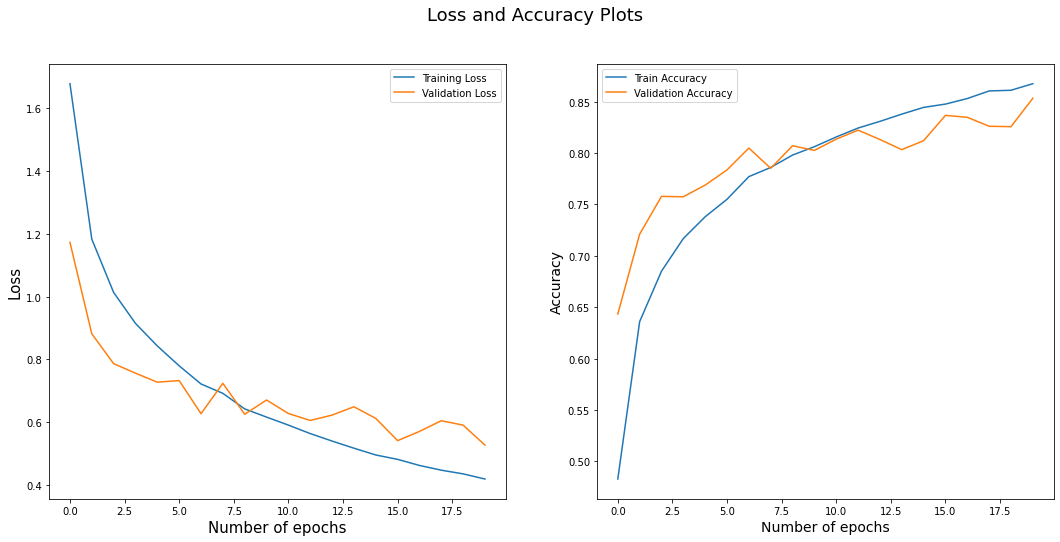

In [ ]:
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(model_history.history['loss'], label='Training Loss')
plt.plot(model_history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(model_history.history['accuracy'], label='Train Accuracy')
plt.plot(model_history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

In [ ]:
valid_loss, valid_accuracy = model.evaluate_generator(generator = valid_generator, verbose = 1)

print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")

165/165 [==============================] - 12s 75ms/step - loss: 0.5272 - accuracy: 0.8534
Validation Accuracy:  85.34 %


In [ ]:
test_generator.reset()
pred=model.predict_generator(test_generator,verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

165/165 [==============================] - 13s 71ms/step


In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

In [ ]:
results.to_csv('res.csv')
test_df.to_csv('test_df.csv')

In [ ]:
count = 0
for x,y in zip(results['Predictions'], test_df['specie_type']):
  if x == y:
    count = count + 1

count



2194

In [ ]:
print("Accuracy :" + str(2165 * 100 /len(results)) + "%")

Accuracy :82.03865100416824%


In [ ]:
test_class_indices = []
for i in test_df['specie_type']:
  test_class_index = birds_encoding2[i]
  test_class_indices.append(test_class_index)

test_class_indices = np.array(test_class_indices)
test_class_indices

array([13, 13,  4, ..., 15,  5, 16])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve,roc_auc_score
cm = confusion_matrix(test_class_indices, predicted_class_indices)
print(cm)


[[ 52   1  10   0   0   3   2   4   0   1   1   0   0   4   2   0   3]
 [  0  25   2   0   0   4   0   0   0   0   0   0   0   0   0   1   2]
 [  0   0 159   0   1   3   3   1   0   0   1   0   2   1   0   0   5]
 [  3   0   4  31   0   2   0   0   2   0   0   0   4   0   0   0   1]
 [  0   1   5   0  91   5   2   0   0   1   1   1   1   3   0   0   1]
 [  0   0  14   0   0 152   2   0   0   0   2   1   1   2   0   2   2]
 [  1   0   8   0   1   6  34   0   0   0   0   2   0   1   0   0   6]
 [  1   1   3   0   0   5   2  44   0   0   0   2   3   1   1   1   1]
 [  1   0   0   1   0   1   1   0  20   0   0   0   0   0   0   0   0]
 [  0   0   2   1   0   0   0   0   0 131   5   0  10   8   0   3   0]
 [  1   0   1   1   0   0   0   0   0   0  77   0   2   2   0   2   0]
 [  2   0   3   0   1   3   3   1   1   0   1  51   3   2   0   0   1]
 [  1   0   2   0   1   7   5   0   1   2   4   0 352  15   1   1   3]
 [  1   1   6   3   0   7   0   0   1  14  11   1  19 568   3   2   9]
 [  0 

In [ ]:
cr = classification_report(test_class_indices, predicted_class_indices, target_names = birds_classes)
print(cr)

              precision    recall  f1-score   support

      skylar       0.79      0.63      0.70        83
      houfin       0.81      0.74      0.77        34
      bcnher       0.67      0.90      0.77       176
      eurwig       0.82      0.66      0.73        47
      houspa       0.95      0.81      0.88       112
      rorpar       0.71      0.85      0.78       178
      dunlin       0.61      0.58      0.59        59
      brnowl       0.85      0.68      0.75        65
      bkbplo       0.80      0.83      0.82        24
      normoc       0.86      0.82      0.84       160
      cangoo       0.73      0.90      0.80        86
     mallar3       0.82      0.71      0.76        72
      wesmea       0.86      0.89      0.88       395
      gnwtea       0.91      0.88      0.89       646
      gwfgoo       0.83      0.89      0.86        44
      comsan       0.84      0.87      0.85       127
      norcar       0.87      0.78      0.82       331

    accuracy              

# Evaluation Metrics from saved models and history
* Loss and Accuracy Plots
* Accuracy score on test set
* Classification Report
* Confusion Matrix

### Loss and Accuracy Plots

In [ ]:
import pickle
with open('/content/drive/MyDrive/Colab Notebooks/birdclef-2022/model/train_history_effnet_with_new_data', "rb") as file_pi:
    new_model_history = pickle.load(file_pi)


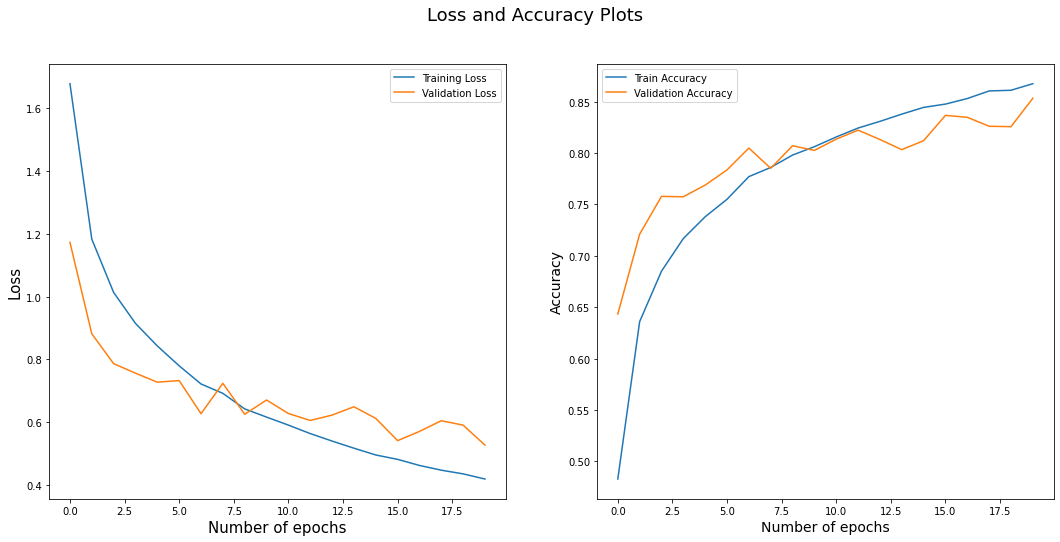

In [ ]:
plt.figure(figsize=(18,8))

plt.suptitle('Loss and Accuracy Plots', fontsize=18)

plt.subplot(1,2,1)
plt.plot(new_model_history['loss'], label='Training Loss')
plt.plot(new_model_history['val_loss'], label='Validation Loss')
plt.legend()
plt.xlabel('Number of epochs', fontsize=15)
plt.ylabel('Loss', fontsize=15)

plt.subplot(1,2,2)
plt.plot(new_model_history['accuracy'], label='Train Accuracy')
plt.plot(new_model_history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.xlabel('Number of epochs', fontsize=14)
plt.ylabel('Accuracy', fontsize=14)
plt.show()

### Validation Accuracy

In [ ]:
new_model = load_model('/content/drive/MyDrive/Colab Notebooks/birdclef-2022/model/effnet-with-new-data.h5')

In [ ]:
valid_loss, valid_accuracy = new_model.evaluate_generator(generator = valid_generator, verbose = 1)

print('Validation Accuracy: ', round((valid_accuracy * 100), 2), "%")

165/165 [==============================] - 13s 73ms/step - loss: 0.5272 - accuracy: 0.8534
Validation Accuracy:  85.34 %


### **Validation Accuracy: *85.34*%**

### Calculating Test Accuracy

In [ ]:
test_generator.reset()
pred=new_model.predict_generator(test_generator,verbose=1)
predicted_class_indices=np.argmax(pred,axis=1)

165/165 [==============================] - 13s 71ms/step


In [ ]:
labels = (train_generator.class_indices)
labels = dict((v,k) for k,v in labels.items())
predictions = [labels[k] for k in predicted_class_indices]

In [ ]:
filenames=test_generator.filenames
results=pd.DataFrame({"Filename":filenames,
                      "Predictions":predictions})

In [ ]:
results.to_csv('/content/drive/MyDrive/Colab Notebooks/birdclef-2022/results/result_using_efficientnet-1.csv')

In [ ]:
count = 0
for x,y in zip(results['Predictions'], test_df['specie_type']):
  if x == y:
    count = count + 1
print("Accuracy:" + str(2165 * 100 /len(results)) + "%")


Accuracy:82.03865100416824%


### Computing classification report

In [ ]:
cr = classification_report(test_class_indices, predicted_class_indices, target_names = birds_classes)
print(cr)

              precision    recall  f1-score   support

      skylar       0.79      0.63      0.70        83
      houfin       0.81      0.74      0.77        34
      bcnher       0.67      0.90      0.77       176
      eurwig       0.82      0.66      0.73        47
      houspa       0.95      0.81      0.88       112
      rorpar       0.71      0.85      0.78       178
      dunlin       0.61      0.58      0.59        59
      brnowl       0.85      0.68      0.75        65
      bkbplo       0.80      0.83      0.82        24
      normoc       0.86      0.82      0.84       160
      cangoo       0.73      0.90      0.80        86
     mallar3       0.82      0.71      0.76        72
      wesmea       0.86      0.89      0.88       395
      gnwtea       0.91      0.88      0.89       646
      gwfgoo       0.83      0.89      0.86        44
      comsan       0.84      0.87      0.85       127
      norcar       0.87      0.78      0.82       331

    accuracy              

### Computing confusion matrix

In [ ]:
test_class_indices = []
for i in test_df['specie_type']:
  test_class_index = birds_encoding2[i]
  test_class_indices.append(test_class_index)

test_class_indices = np.array(test_class_indices)
test_class_indices

array([13, 13,  4, ..., 15,  5, 16])

In [ ]:
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report, roc_curve,roc_auc_score
cm = confusion_matrix(test_class_indices, predicted_class_indices)
print(cm)


[[ 52   1  10   0   0   3   2   4   0   1   1   0   0   4   2   0   3]
 [  0  25   2   0   0   4   0   0   0   0   0   0   0   0   0   1   2]
 [  0   0 159   0   1   3   3   1   0   0   1   0   2   1   0   0   5]
 [  3   0   4  31   0   2   0   0   2   0   0   0   4   0   0   0   1]
 [  0   1   5   0  91   5   2   0   0   1   1   1   1   3   0   0   1]
 [  0   0  14   0   0 152   2   0   0   0   2   1   1   2   0   2   2]
 [  1   0   8   0   1   6  34   0   0   0   0   2   0   1   0   0   6]
 [  1   1   3   0   0   5   2  44   0   0   0   2   3   1   1   1   1]
 [  1   0   0   1   0   1   1   0  20   0   0   0   0   0   0   0   0]
 [  0   0   2   1   0   0   0   0   0 131   5   0  10   8   0   3   0]
 [  1   0   1   1   0   0   0   0   0   0  77   0   2   2   0   2   0]
 [  2   0   3   0   1   3   3   1   1   0   1  51   3   2   0   0   1]
 [  1   0   2   0   1   7   5   0   1   2   4   0 352  15   1   1   3]
 [  1   1   6   3   0   7   0   0   1  14  11   1  19 568   3   2   9]
 [  0 